In [4]:
#import libraries
import pandas as pd
print('pandas: %s' % pd.__version__)

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 150)

import numpy as np
print('geopandas: %s' % np.__version__)

# Tensorflow / Keras
import tensorflow as tf # used to access argmax function
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense # for creating regular densely-connected NN layer.
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout # for adding Concolutional and densely-connected NN layers.
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

import decimal
from decimal import Decimal

import keras 
import tensorflow as tf
from tensorflow.keras.layers import Dropout,BatchNormalization,Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from keras import callbacks
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense # for creating regular densely-connected NN layer.
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,MaxPooling2D # for adding Concolutional and densely-connected NN layers.
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

from pathlib import Path  

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder # for encoding labels
from keras.models import load_model
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import plot_model

from sklearn.utils.class_weight import compute_sample_weight

import pickle

pandas: 1.5.0
geopandas: 1.23.2
Tensorflow/Keras: 2.10.0
pandas: 1.5.0
numpy: 1.23.2


In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [2]:
# slow
def extract_images(df, variables, verbose=False):
    number_of_img, rows, cols = len(df.time.unique()), len(df.latitude.unique()), len(df.longitude.unique())
    images = np.zeros( (number_of_img, rows, cols, len(variables)) )
    
    df = df.sort_values(by=['time','latitude','longitude'])
    k=0
    
    for day in range(0,number_of_img):
        
        a=df.iloc[377*day:377*(day+1)]
        i=0
        for var in variables:
            images[day,:,:,i] = a.pivot(index='latitude', columns='longitude').sort_index(ascending=False)[var]
            i+=1
        k+=1
        if (k%100==0) & (verbose==True): print(k)
    return images

In [3]:
# faster
def extract_images_new(df, n_filters, verbose=False):
    times = df.time.unique()
    number_of_img, rows, cols = len(times), len(df.latitude.unique()), len(df.longitude.unique())
    images = np.zeros( (number_of_img, rows, cols, n_filters) )
    
    df = df.set_index(['time','latitude','longitude'], drop=True)
    df.sort_index(level=['time','latitude', 'longitude'], ascending=[1,0,1], inplace=True)
    k=0
    
    for day in range(0,number_of_img):
        
        images[k,:,:,:] = df.loc(axis=0)[times[day]].values.reshape(rows,cols,n_filters)
        if (k%100==0) & (verbose==True): print(k)
        k += 1
    return images


In [ ]:
train = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/training_sets_withrealtom.csv')
val = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/validation_sets_withrealtom.csv')
test = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/test_sets_withrealtom.csv')
test = test.loc[test.time>='2016-04-01']

train['shear'] = train.apply(lambda x: np.sqrt((x.u_200-x.u_850)**2 + (x.v_200-x.v_850)**2),axis=1)
val['shear'] = val.apply(lambda x: np.sqrt((x.u_200-x.u_850)**2 + (x.v_200-x.v_850)**2),axis=1)
test['shear'] = test.apply(lambda x: np.sqrt((x.u_200-x.u_850)**2 + (x.v_200-x.v_850)**2),axis=1)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cols_to_std = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']
train_std,val_std,test_std = train,val,test

# apply standardization on numerical features
train_std[cols_to_std] = scaler.fit_transform(train[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']])
val_std[cols_to_std] = scaler.transform(val[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']])
test_std[cols_to_std] = scaler.transform(test[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']])


In [24]:
%%time
#training set has 11323 days
variables = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']
train_img_std = extract_images(train_std, variables, verbose=True)
print(train_img_std.shape)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
(11323, 13, 29, 9)
CPU times: user 2min 11s, sys: 676 ms, total: 2min 12s
Wall time: 2min 12s


In [30]:
%%time
#training set has 11323 days
train_std_red = train_std.loc[:,['time','latitude','longitude','vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']]
train_img_std_new = extract_images_new(train_std_red, 9, verbose=True)
print(train_img_std.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
(11323, 13, 29, 9)
CPU times: user 1.7 s, sys: 843 ms, total: 2.54 s
Wall time: 3.02 s


In [33]:
train_img_std_new[(train_img_std_new-train_img_std)>0]

array([], dtype=float64)

# World test

In [11]:
%%time
new_test = pd.read_csv('/Users/paolo/Desktop/TC_world/test_world.csv')
new_test['shear'] = np.sqrt((new_test['u_200']-new_test['u_850'])**2 + (new_test['v_200']-new_test['v_850'])**2)


CPU times: user 6.99 s, sys: 1.95 s, total: 8.95 s
Wall time: 15.9 s


In [12]:
new_test

,Unnamed: 0,time,latitude,longitude,vo,r,u_200,u_850,v_200,v_850,ttr,sst,new_target,Real_tom_target,shear
0,0,2016-01-01,90.0,0.0,0.000043,81.503310,12.107742,-5.164993,17.249031,-4.722889,-170.39037,271.45947,0.0,0.0,27.948393
1,1,2016-01-01,90.0,2.5,0.000045,81.257750,12.948624,-5.211590,16.924652,-4.370609,-170.39037,271.45947,0.0,0.0,27.987167
2,2,2016-01-01,90.0,5.0,0.000047,81.058260,13.782364,-5.238873,16.558777,-4.030861,-170.94148,271.45947,0.0,0.0,28.031065
3,3,2016-01-01,90.0,7.5,0.000049,80.905945,14.606613,-5.250248,16.149963,-3.704582,-171.19629,271.45947,0.0,0.0,28.080205
4,4,2016-01-01,90.0,10.0,0.000051,80.799100,15.419373,-5.248001,15.697968,-3.391552,-171.17259,271.45947,0.0,0.0,28.134501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13439587,1918435,2022-12-31,-90.0,167.5,0.000016,97.887580,-1.422317,2.364288,-3.507492,0.720871,-182.42667,0.00000,0.0,0.0,5.676041
13439588,1918436,2022-12-31,-90.0,170.0,0.000016,97.870000,-1.215286,2.370148,-3.650070,0.809738,-182.44444,0.00000,0.0,0.0,5.722345
13439589,1918437,2022-12-31,-90.0,172.5,0.000017,97.856330,-1.002396,2.372101,-3.778976,0.898605,-182.46222,0.00000,0.0,0.0,5.767755
13439590,1918438,2022-12-31,-90.0,175.0,0.000017,97.844610,-0.783646,2.370148,-3.892258,0.987473,-182.58667,0.00000,0.0,0.0,5.810179


In [45]:
%%time
variables = ['time','latitude','longitude', 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst']
new_test_img =  extract_images_new(new_test.loc[:,variables], 8, verbose=True)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
CPU times: user 3.16 s, sys: 3.78 s, total: 6.94 s
Wall time: 24.9 s


# Read world images

In [50]:
def evaluate_perf(test_inputs,test_outputs,day=0):
    t = model.predict(test_inputs)
    one_day_t = t
    one_day_y = test_outputs
    
    ranges = [0.025,0.05,0.075,0.1]
    
    for j in ranges:
        classes = []
        for i in one_day_t.reshape(-1,1):
            if i<=j: classes.append(0)
            else: classes.append(1)
    
    # confusion matrix with threshold on 0.1, otherwise always 0 
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
        ConfusionMatrixDisplay(confusion_matrix(one_day_y.reshape(-1,1), classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
    
    plot_roc(one_day_t.reshape(-1,1),one_day_y.reshape(-1,1))
    
    display = CalibrationDisplay.from_predictions(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1), n_bins=10)

    print(f'All zeros Brier score: {brier_score_loss(one_day_y.reshape(-1,1), np.zeros(len(one_day_y.reshape(-1,1))))}')
    print(f'Model Brier score: {brier_score_loss(one_day_y.reshape(-1,1), one_day_t.reshape(-1,1))}')
    

In [8]:
### features
#train = pd.read_pickle('/Users/paolo/Desktop/TC_world/train_world_img.pkl')
val = pd.read_pickle('/Users/paolo/Desktop/TC_world/val_world_img.pkl')
test = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_world_img.pkl')
test.shape

(2557, 73, 72, 9)

In [14]:
minitrain = train[0:64,:,:,:]
minival = val[0:64,:,:,:]

In [15]:
### target

train_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/train_target_img.pkl')
val_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/val_target_img.pkl')
test_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_target_img.pkl')

In [41]:
val_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/val_target_img.pkl')
val_target.shape

(1826, 13, 29, 1)

In [16]:
minitrain_target = train_target[0:64,:,:,:]
minival_target = val_target[0:64,:,:,:]

In [45]:
def Generator(File_address, target_address , Batch_Size):
    #while True:
    pickle_data = pd.read_pickle(File_address)
    pickle_target = pd.read_pickle(target_address)
        #with (open(File_address, "rb")) as openfile: 
        #    while True:
        #        pickle_data.append(pickle.load(openfile))
        #with (open(target_address, "rb")) as openfile: 
        #        pickle_target.append(pickle.load(openfile))
    while True:
        for B in range(0, len(pickle_data), Batch_Size):
            X = pickle_data[B:B+Batch_Size]
            Y = pickle_target[B:B+Batch_Size] 
            yield X, Y


In [31]:
train_path = '/Users/paolo/Desktop/TC_world/val_world_img.pkl'
train_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'
#x1,y1 = Generator(train_path, train_target_path, 32)
#print(x1)
#print(y1)
x = Generator(train_path, train_target_path, 32)

In [32]:
for i,j in x:
    print(i,j)

[[[[ 4.32046121e-01  1.10626916e+00 -3.91840987e-02 ...  1.35543217e+00
     7.21149932e-01 -1.97251871e-01]
   [ 4.54648028e-01  1.09339941e+00 -6.18523688e-02 ...  1.35543217e+00
     7.21149932e-01 -1.99024882e-01]
   [ 4.77958864e-01  1.08008746e+00 -8.53457871e-02 ...  1.35506447e+00
     7.21149932e-01 -2.00725360e-01]
   ...
   [-1.14492789e-01  1.55189199e+00 -1.44512711e+00 ...  1.34758906e+00
     7.21149932e-01 -3.49193553e-01]
   [-1.26067927e-01  1.55523588e+00 -1.43282469e+00 ...  1.34709895e+00
     7.21149932e-01 -3.50695487e-01]
   [-1.40394824e-01  1.55698993e+00 -1.41900119e+00 ...  1.34642498e+00
     7.21149932e-01 -3.52102154e-01]]

  [[ 1.00725360e+00  4.83291335e-01 -2.78963075e-02 ...  1.31168235e+00
     7.21149932e-01 -1.52502826e-01]
   [ 1.02556611e+00  5.01399495e-01 -6.04584607e-02 ...  1.29029776e+00
     7.21149932e-01 -1.65820773e-01]
   [ 1.03302101e+00  5.21886451e-01 -9.33458917e-02 ...  1.26854549e+00
     7.21149932e-01 -1.79403128e-01]
   ...
   

    -1.20212225e+00 -2.31305434e-01]]]] [[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]

# basic CNN

In [36]:
model = Sequential()
model.add(layers.Input(shape=(73,72, 9)))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3,3), padding='same'))

#model.add(layers.Flatten())

#model.add(layers.Reshape((2,4,16)))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3,3), padding='same'))

model.add(layers.Conv2D(8, (5,5), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2,4)))

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # sigmoidal activation to have probabilities

model.add(layers.Cropping2D(cropping=((2,3),(1,2))))

model.summary()


model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)


Metal device set to: Apple M1


2023-04-13 07:39:35.253742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-13 07:39:35.256406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 72, 8)         1808      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 24, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 24, 8)         1608      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 8, 8)           1608      
                                                                 
 up_sampling2d (UpSampling2D  (None, 18, 32, 8)        0

In [48]:
train_path = '/Users/paolo/Desktop/TC_world/train_world_img.pkl'
train_target_path = '/Users/paolo/Desktop/TC_world/train_target_img.pkl'
val_path = '/Users/paolo/Desktop/TC_world/val_world_img.pkl'
val_target_path = '/Users/paolo/Desktop/TC_world/val_target_img.pkl'

train_gen = Generator(train_path, train_target_path, 32)
val_gen = Generator(val_path, val_target_path, 32)

#Model.fit(train_gen, epochs=100, steps_per_epoch=Number_of_sampels//32)
model.fit(train_gen, validation_data=val_gen,
        callbacks=[monitor],epochs=100, steps_per_epoch=11323//32, validation_steps=1826//32)

Epoch 1/100
353/353 [==============================] - 23s 64ms/step - loss: 0.0235 - val_loss: 0.0205
Epoch 2/100
353/353 [==============================] - 27s 74ms/step - loss: 0.0232 - val_loss: 0.0203
Epoch 3/100
353/353 [==============================] - 19s 54ms/step - loss: 0.0229 - val_loss: 0.0200
Epoch 4/100
353/353 [==============================] - 25s 70ms/step - loss: 0.0227 - val_loss: 0.0197
Epoch 5/100
353/353 [==============================] - 26s 73ms/step - loss: 0.0224 - val_loss: 0.0192
Epoch 6/100
353/353 [==============================] - 16s 47ms/step - loss: 0.0220 - val_loss: 0.0187
Epoch 7/100
353/353 [==============================] - 19s 53ms/step - loss: 0.0213 - val_loss: 0.0174
Epoch 8/100
353/353 [==============================] - 15s 41ms/step - loss: 0.0199 - val_loss: 0.0156
Epoch 9/100
353/353 [==============================] - 14s 40ms/step - loss: 0.0183 - val_loss: 0.0140
Epoch 10/100
353/353 [==============================] - 15s 44ms/step - l

78/78 [==============================] - 1s 9ms/step


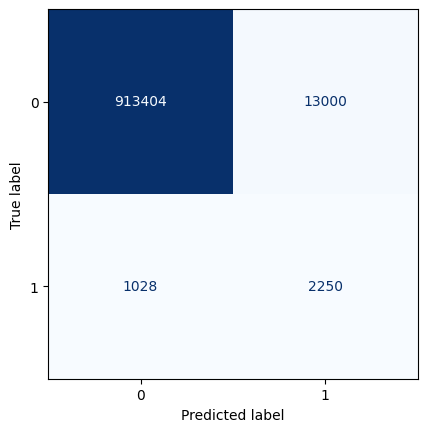

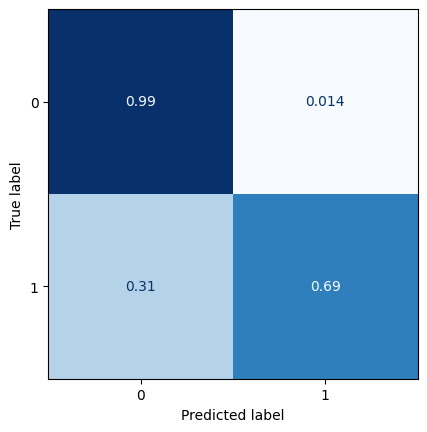

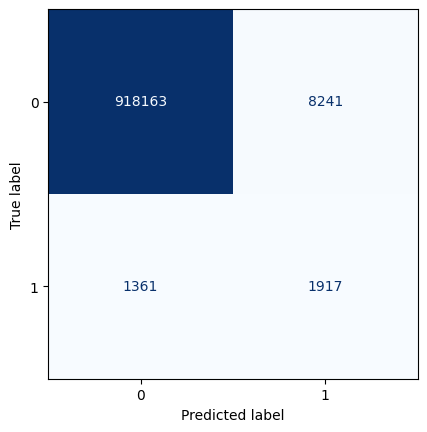

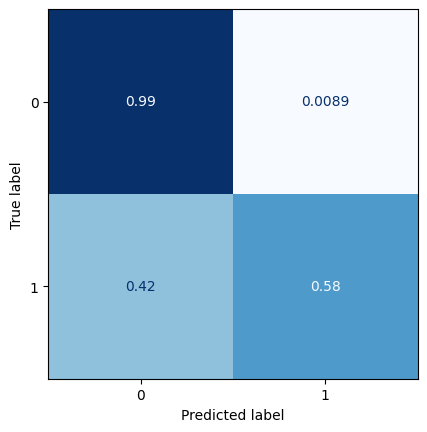

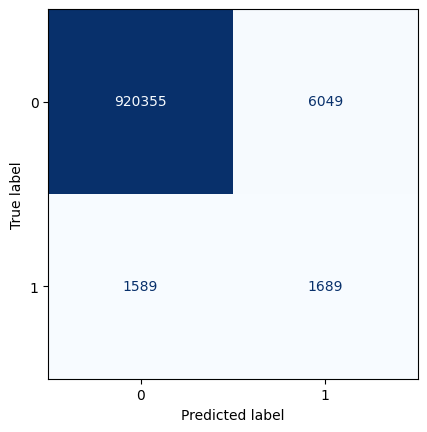

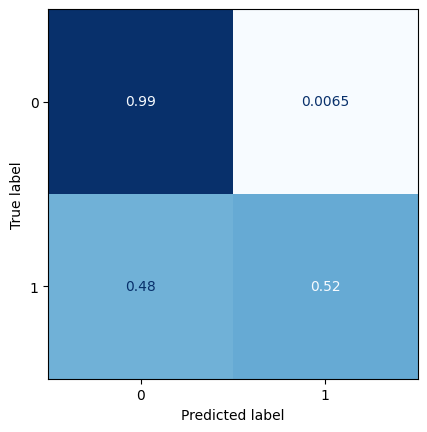

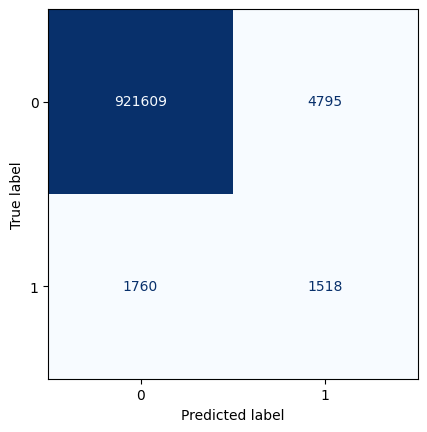

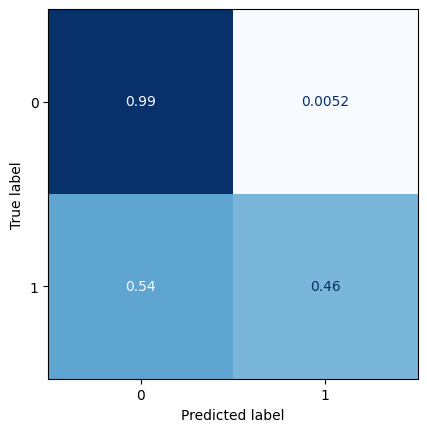

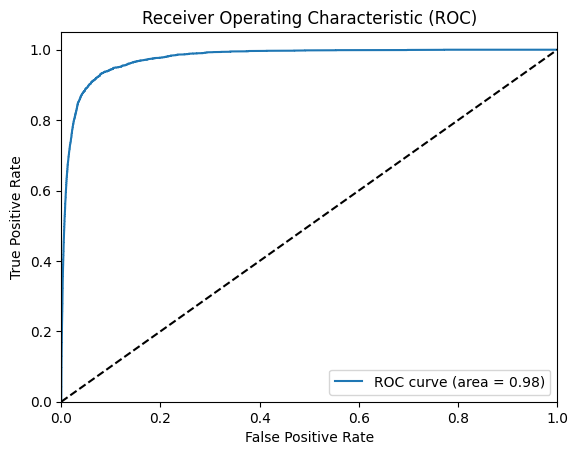

All zeros Brier score: 0.0035259368257102965
Model Brier score: 0.003016965153756049


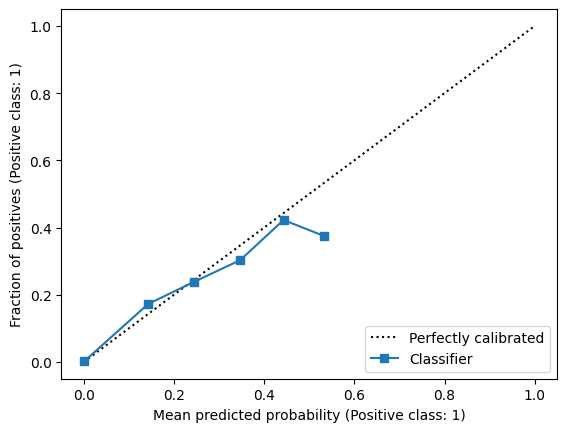

In [59]:
test = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_world_img.pkl')
test_target = pd.read_pickle('/Users/paolo/Desktop/TC_world/test_target_img.pkl')
evaluate_perf(test[91:],test_target,day=0)


### generator

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = '/Users/paolo/Desktop/TC_world/train_world_img.pkl'
val_dir = '/Users/paolo/Desktop/TC_world/val_world_img.pkl'
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,batch_size=20)
val_generator = val_datagen.flow_from_directory(val_dir,batch_size=20)

NotADirectoryError: [Errno 20] Not a directory: '/Users/paolo/Desktop/TC_world/train_world_img.pkl'

In [ ]:
train_generator = train_datagen.flow_from_directory(
 # This is the target directory
 train_dir,
 # All images will be resized to 150x150
 target_size=(150, 150),
 batch_size=20,
 # Since we use binary_crossentropy loss, we need binary labels
 class_mode='binary')

In [9]:
model.fit(minitrain, minitrain_target, validation_data=(minival,minival_target),
        callbacks=[monitor],epochs=100, batch_size=32)

Epoch 1/100


2023-04-05 17:44:37.440524: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-05 17:44:37.818343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.2977 - val_loss: 0.1988
Epoch 2/100
1/1 [==============================] - 0s 59ms/step - loss: 0.2202 - val_loss: 0.1306
Epoch 3/100
1/1 [==============================] - 0s 43ms/step - loss: 0.1581 - val_loss: 0.0792
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1135

2023-04-05 17:44:38.723669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 48ms/step - loss: 0.1135 - val_loss: 0.0451
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0873 - val_loss: 0.0250
Epoch 6/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0766 - val_loss: 0.0144
Epoch 7/100
1/1 [==============================] - 0s 50ms/step - loss: 0.0753 - val_loss: 0.0088
Epoch 8/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0776 - val_loss: 0.0059
Epoch 9/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0803 - val_loss: 0.0043
Epoch 10/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0821 - val_loss: 0.0034
Epoch 11/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0827 - val_loss: 0.0029
Epoch 12/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0823 - val_loss: 0.0026
Epoch 13/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0810 - val_loss: 0.0026
Epoch 14/100
1/1 [==========